#### Imports

In [1]:
import pathlib
import os
import os.path as osp
import sys
import argparse
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
# from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero

from utils.MyMovieLens import MyMovieLens
from utils.gnn_simple import Model
from utils.train_test import train_test
from utils.visualize import plot_loss, plot_train, plot_val, plot_test
from utils.suggestions import make_recommendations, get_reviews_suggestions_intersection, get_user_suggestions, get_user_reviews, analyze_user

/home/atha/diploma/environ/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read the dataset

In [3]:
path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLens')
dataset = MyMovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

#### Preprocess the dataset

In [4]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

#### Define and train-test the model

In [5]:
model = Model(
    data,
    layer_name="SAGE",
    encoder_num_layers=5,
    encoder_dropout=0.1,
    encoder_skip_connections=True,
    decoder_num_layers=4,
    hidden_channels=32
).to(device)
losses = train_test(
    model=model,
    epochs=1000,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    logging_step=1
)

/home/atha/diploma/environ/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 001, Loss: 18.1725, Train: 3.1287, Val: 3.1235, Test: 3.1495
Epoch: 002, Loss: 15.2480, Train: 1.9136, Val: 1.9339, Test: 1.9489
Epoch: 003, Loss: 7.3015, Train: 1.9782, Val: 1.9702, Test: 1.9351
Epoch: 004, Loss: 67.4875, Train: 1.1585, Val: 1.1910, Test: 1.1684
Epoch: 005, Loss: 6.7654, Train: 2.3362, Val: 2.3425, Test: 2.3595
Epoch: 006, Loss: 9.2047, Train: 2.8597, Val: 2.8519, Test: 2.8835
Epoch: 007, Loss: 12.8358, Train: 3.0764, Val: 3.0689, Test: 3.0972
Epoch: 008, Loss: 14.7563, Train: 3.1695, Val: 3.1639, Test: 3.1909
Epoch: 009, Loss: 15.6435, Train: 3.2063, Val: 3.1990, Test: 3.2268
Epoch: 010, Loss: 15.9789, Train: 3.2166, Val: 3.2096, Test: 3.2377
Epoch: 011, Loss: 16.0820, Train: 3.2147, Val: 3.2071, Test: 3.2351
Epoch: 012, Loss: 16.0626, Train: 3.2041, Val: 3.1972, Test: 3.2246
Epoch: 013, Loss: 15.9559, Train: 3.1871, Val: 3.1798, Test: 3.2068
Epoch: 014, Loss: 15.7916, Train: 3.1641, Val: 3.1564, Test: 3.1841
Epoch: 015, Loss: 15.5756, Train: 3.1336, Val: 3.12

#### Visualize

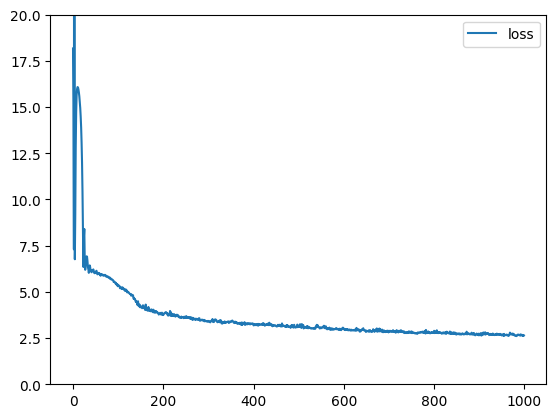

In [6]:
plot_loss({ "loss": losses }, ylim=20)

#### Examining the predictions

In [7]:
results = make_recommendations(dataset, data, model)

In [8]:
get_reviews_suggestions_intersection(dataset, results)

100%|██████████| 610/610 [00:13<00:00, 44.95it/s]

Users that got suggestions of movies they have already rated: 3 %
Average number of suggested movies per user: 38
Average number of rated movies per user: 165


I observe that when more epochs are being run (better training):
* percentage of suggested movies that have already been reviewed is being reduced
* average number of suggested movies per user is being reduced 

In [9]:
analyze_user(dataset, results, user_id=4)

[('Flirting With Disaster (1996)', 5.0), ('Crumb (1994)', 5.0), ('Living in Oblivion (1995)', 5.0), ('Before Sunrise (1995)', 5.0), ('Eat Drink Man Woman (Yin shi nan nu) (1994)', 5.0), ('Star Wars: Episode IV - A New Hope (1977)', 5.0), ('Like Water for Chocolate (Como agua para chocolate) (1992)', 5.0), ('Shallow Grave (1994)', 5.0), ("Muriel's Wedding (1994)", 5.0), ('Fugitive, The (1993)', 5.0), ('In the Name of the Father (1993)', 5.0), ('Manhattan Murder Mystery (1993)', 5.0), ('Six Degrees of Separation (1993)', 5.0), ('Silence of the Lambs, The (1991)', 5.0), ('Fargo (1996)', 5.0), ('Philadelphia Story, The (1940)', 5.0), ('North by Northwest (1959)', 5.0), ('Some Like It Hot (1959)', 5.0), ('Casablanca (1942)', 5.0), ('My Fair Lady (1964)', 5.0), ('Wizard of Oz, The (1939)', 5.0), ('Gone with the Wind (1939)', 5.0), ('Notorious (1946)', 5.0), ('Beautiful Thing (1996)', 5.0), ('Sleeper (1973)', 5.0), ("Monty Python's Life of Brian (1979)", 5.0), ('Bonnie and Clyde (1967)', 5.0)